<a href="https://colab.research.google.com/github/jrtkst/finstocks_with_CNN/blob/main/Financial_Stock_Trading_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Load Dataset**

In this section, we will load the dataset which to be used in the model training and testing. The data is loaded using the help of *yahoo_fin* packages. We will also the *ta* package, which stands for technical analysis to calculate the technical indicators.

In [ ]:
pip install pandas-ta &> /dev/null # ta package for technical analysis.

In [ ]:
pip install ta &> /dev/null # ta package for technical analysis.

In [ ]:
pip install yahoo_fin &> /dev/null # yahoo_fin package to load the stocks dataset.

In [ ]:
# importing the libraries
from datetime import datetime, date
import pandas as pd
import numpy as np
import random
from collections import OrderedDict
from yahoo_fin.stock_info import get_data
import ta 
import pandas_ta as pd_ta

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
# Important Functions
def one_hot(y,n):
    '''
    y : array about to be one-hot-encoded
    n : numbers of different classes
    '''
    return torch.eye(n)[y.reshape(1,y.shape[0])[0]]

def rev_one_hot(y):
    '''
    The inverse of one_hot function
    '''
    return np.argmax(y, axis=1)

def pred(net, x_test, one_hot=True):
    ''' 
    Making a prediction based on a trained neural network
    net     : the already trained neural network
    x_test  : the features data for testing
    one_hot : (optional) if True, returns a one-hot-encoded prediction. Default = True
    '''
    with torch.no_grad():
        pred = net(x_test)
    if not one_hot:
        return rev_one_hot(pred)
    return pred

def accuracy(y_hat, y_true):
    '''
    Counting the accuracy. Expecting an input of non one-hot-encoded predictions
    '''
    return torch.sum(y_hat.reshape(-1,1)==y_true.reshape(-1,1))/len(y_hat)*100

We fetch the daily IBM, AAPL, and MSFT stock data starting from January 1, 2003 to January 1, 2022

In [ ]:
today = date.today()
IBM_daily = get_data("ibm", start_date="01/01/2003", end_date="01/01/2022", index_as_date = False, interval="1d")
IBM_daily["year"] = [x.year for x in IBM_daily["date"]]
print("IBM Stocks Data : \n")
IBM_daily

IBM Stocks Data : 



,date,open,high,low,close,adjclose,volume,ticker,year
0,2003-01-02,75.334610,77.026772,74.751434,77.026772,46.928150,8226267,IBM,2003
1,2003-01-03,77.151054,78.059273,76.682602,78.059273,47.557182,6236566,IBM,2003
2,2003-01-06,78.298279,81.070747,78.212234,79.913956,48.687160,8285680,IBM,2003
3,2003-01-07,80.258125,82.390060,80.066925,82.217972,50.090847,12454617,IBM,2003
4,2003-01-08,81.787766,81.921608,80.372849,80.487572,49.036606,9946205,IBM,2003
...,...,...,...,...,...,...,...,...,...
4779,2021-12-27,130.630005,131.649994,129.949997,131.619995,130.053436,4293900,IBM,2021
4780,2021-12-28,131.600006,133.220001,131.589996,132.630005,131.051422,3445200,IBM,2021
4781,2021-12-29,132.399994,134.210007,132.300003,133.350006,131.762848,4239900,IBM,2021
4782,2021-12-30,133.750000,134.369995,133.330002,133.910004,132.316193,3158100,IBM,2021


In [ ]:
AAPL_daily = get_data("aapl", start_date="01/01/2003", end_date="01/01/2022", index_as_date = False, interval="1d")
AAPL_daily["year"] = [x.year for x in AAPL_daily["date"]]
print("AAPL Stocks Data : \n")
AAPL_daily

AAPL Stocks Data : 



,date,open,high,low,close,adjclose,volume,ticker,year
0,2003-01-02,0.256429,0.266429,0.256250,0.264286,0.226301,181428800,AAPL,2003
1,2003-01-03,0.264286,0.266607,0.260536,0.266071,0.227830,147453600,AAPL,2003
2,2003-01-06,0.268393,0.274643,0.265714,0.266071,0.227830,390532800,AAPL,2003
3,2003-01-07,0.264107,0.267857,0.258393,0.265179,0.227066,342344800,AAPL,2003
4,2003-01-08,0.260357,0.262679,0.257857,0.259821,0.222478,229644800,AAPL,2003
...,...,...,...,...,...,...,...,...,...
4779,2021-12-27,177.089996,180.419998,177.070007,180.330002,180.100540,74919600,AAPL,2021
4780,2021-12-28,180.160004,181.330002,178.529999,179.289993,179.061859,79144300,AAPL,2021
4781,2021-12-29,179.330002,180.630005,178.139999,179.380005,179.151749,62348900,AAPL,2021
4782,2021-12-30,179.470001,180.570007,178.089996,178.199997,177.973251,59773000,AAPL,2021


In [ ]:
MSFT_daily = get_data("msft", start_date="01/01/2003", end_date="01/01/2022", index_as_date = False, interval="1d")
MSFT_daily["year"] = [x.year for x in MSFT_daily["date"]]
print("MSFT Stocks Data : \n")
MSFT_daily

MSFT Stocks Data : 



,date,open,high,low,close,adjclose,volume,ticker,year
0,2003-01-02,26.150000,26.875000,25.855000,26.860001,16.922308,67025200,MSFT,2003
1,2003-01-03,26.795000,26.900000,26.440001,26.895000,16.944361,55546800,MSFT,2003
2,2003-01-06,27.010000,27.615000,26.900000,27.385000,17.253061,59456200,MSFT,2003
3,2003-01-07,27.459999,28.004999,27.340000,27.900000,17.577534,80517400,MSFT,2003
4,2003-01-08,27.684999,27.775000,27.055000,27.120001,17.086115,64566000,MSFT,2003
...,...,...,...,...,...,...,...,...,...
4779,2021-12-27,335.459991,342.480011,335.429993,342.450012,341.743378,19947000,MSFT,2021
4780,2021-12-28,343.149994,343.809998,340.320007,341.250000,340.545837,15661500,MSFT,2021
4781,2021-12-29,341.299988,344.299988,339.679993,341.950012,341.244415,15042000,MSFT,2021
4782,2021-12-30,341.910004,343.130005,338.820007,339.320007,338.619843,15994500,MSFT,2021


## **1.1 Labelling**

In [ ]:
def labelling(Data, window=11):
    '''
    Labelling of the stock prices data based on the closed price. 
    The labelling is based on a sliding window with default length 11.
    On each sliding window, the day with the largest closed price is labelled as "sell",
    the one with the smallest closed price is labelled as "buy", and the rest labelled as "hold".

    Input : series, 1d array, time series of stock’s closed price
	Output : action, 1d array, based on the labelling explained above
    '''
    num_data= len(Data)
    act = [0 for j in range(num_data)] # 0 == hold
    num_windows = num_data // window
    rest = num_data % window
    for k in range(num_windows):
        wind = Data[k*window:(k+1)*window]
        max = np.max(wind)
        min = np.min(wind)
        find_max = True
        find_min = True
        for i in range(window-1,-1,-1):
            if wind[i] == max and find_max:
                max_idx = window*k + i
                find_max = False
            if wind[i] == min and find_min:
                min_idx = window*k + i
                find_min = False
        act[max_idx] = 1 # 1 == sell
        act[min_idx] = 2 # 2 == buy

    wind = Data[num_windows*window:]
    max = np.max(wind)
    min = np.min(wind)
    find_max = True
    find_min = True
    for i in range(rest-1,-1,-1):
        if wind[i] == max and find_max:
            max_idx = num_windows*window + i
            find_max = False
        if wind[i] == min and find_min:
            min_idx = num_windows*window + i
            find_min = False
    act[max_idx] = 1 # 1 == sell
    act[min_idx] = 2 # 2 == buy

    return act


In [ ]:
AAPL_daily["action"] = labelling(np.array(AAPL_daily["close"]))
MSFT_daily["action"] = labelling(np.array(MSFT_daily["close"]))
IBM_daily["action"] = labelling(np.array(IBM_daily["close"]))
print("After labelling: \n", IBM_daily[["date", "close", "action", "ticker"]][:15])

After labelling: 
          date      close  action ticker
0  2003-01-02  77.026772       2    IBM
1  2003-01-03  78.059273       0    IBM
2  2003-01-06  79.913956       0    IBM
3  2003-01-07  82.217972       0    IBM
4  2003-01-08  80.487572       0    IBM
5  2003-01-09  83.173996       0    IBM
6  2003-01-10  83.824089       0    IBM
7  2003-01-13  83.661568       0    IBM
8  2003-01-14  84.684509       1    IBM
9  2003-01-15  83.738052       0    IBM
10 2003-01-16  82.265778       0    IBM
11 2003-01-17  77.724663       1    IBM
12 2003-01-21  76.998085       0    IBM
13 2003-01-22  76.195030       0    IBM
14 2003-01-23  77.485657       0    IBM


## **1.2 Technical Indicators Calculation**

In this subsection, we will calculate 15 different technical indicators using the dataset above for 15 different time windows. The technical indicators used are


1.   RSI
2.   CMO
3.   William%R
4.   MACD
5.   WMA
6.   PPO
7.   EMA
8.   ROC
9.   SMA
10.  CMFI
11.  HMA
12.  DMI
13.  TripleEMA
14.  PSl
15.  CCI



In [ ]:
def Image_Gen(Data):
    '''
    Input : stock prices time series data with columns : {"close", "high", "low"}
    Output : images generated from the stock prices data, with different indicators on each row and different length/window on each column
    '''
    num_data = len(Data.iloc[:, 0])
    data_image = np.zeros((num_data, 15, 15))
    for k in range(15):
        n = k + 6
        data_image[:,0,k] = ta.momentum.rsi(Data["close"], window=n, fillna=True) # RSI
        data_image[:,1,k] = pd_ta.cmo(Data["close"], length=n).fillna(0) # CMO
        data_image[:,2,k] = ta.momentum.williams_r(Data["high"], Data["low"], Data["close"], lbp=n, fillna=True) # william%R
        data_image[:,3,k] = pd_ta.macd(Data["close"], fast=n, slow=n+5).iloc[:, 0].fillna(0) # MACD
        data_image[:,4,k] = ta.trend.wma_indicator(Data["close"], window=n, fillna=True) # WMA
        data_image[:,5,k] = ta.momentum.ppo(Data["close"], window_slow=2*n, window_fast=n, fillna=True) #PPO
        data_image[:,6,k] = ta.trend.ema_indicator(Data["close"], window=n, fillna=True) # EMA
        data_image[:,7,k] = ta.momentum.roc(Data["close"], window=n, fillna=True) # ROC
        data_image[:,8,k] = ta.trend.sma_indicator(Data["close"], window=n, fillna=True) # SMA
        data_image[:,9,k] = pd_ta.cmf(Data["high"], Data["low"], Data["close"], Data["volume"], length=n, fillna=0) # CMFI
        data_image[:,10,k] = pd_ta.hma(Data["close"], length=n).fillna(0) # HMA
        data_image[:,11,k] = ta.trend.adx_neg(Data["high"], Data["low"], Data["close"], window=n, fillna=True) # DMI
        data_image[:,12,k] = pd_ta.tema(Data["close"], length=n).fillna(0) # TripleEMA
        data_image[:,13,k] = pd_ta.psl(Data["close"], length=n).fillna(0) # PSl
        data_image[:,14,k] = ta.trend.cci(Data["high"], Data["low"], Data["close"], window=n, fillna=True) # CCI
        

    return data_image.reshape(-1, 1, 15, 15)

After that, we are gonna generate the data labels for the images created above as a one hot encoded vector. 

# **2. Model Training**

## **2.1 CNN Architecture**

In this section, we will develop a CNN model for the trading algorithm. We are going to be using the **PyTorch** package as the main tools for constructing the CNN model. \\

The CNN structures consists of several layers illustrated on the figure below:


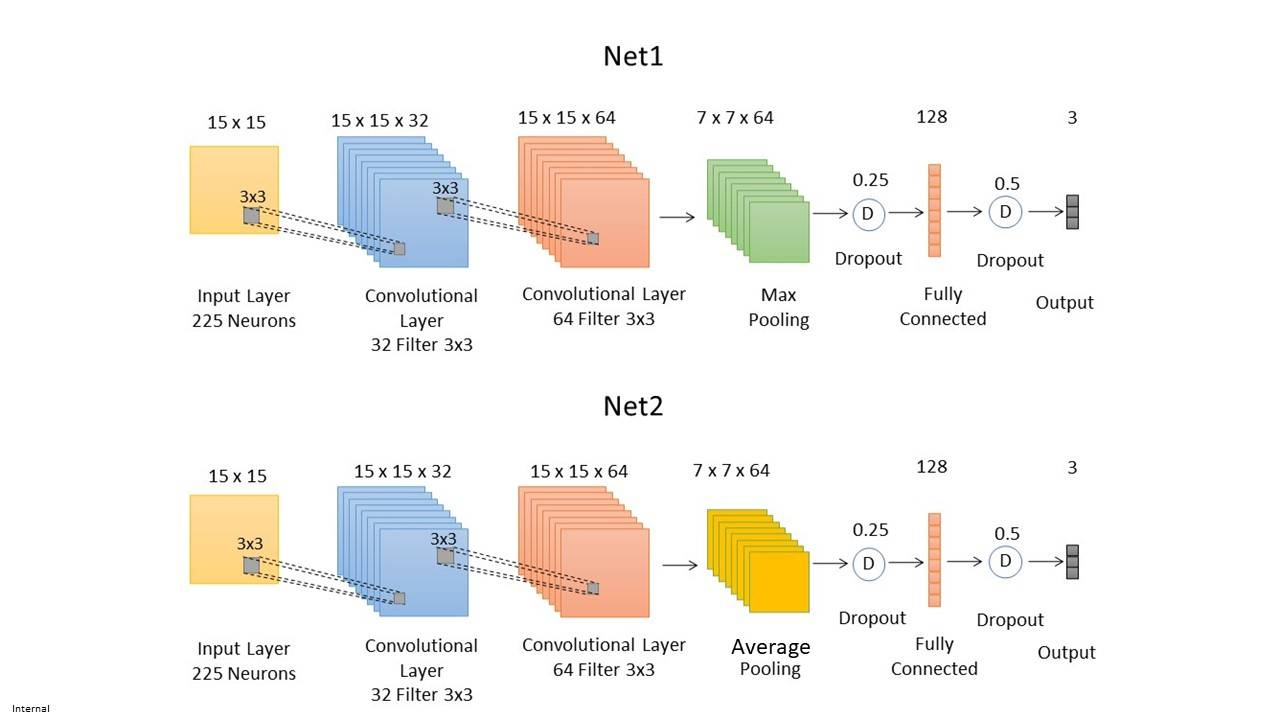

The only difference between the **Net1** and **Net2** is that the Net2 architecture uses a **Average Pooling** layer instead of a **Maximum Pooling**. 

In [ ]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.Norm1 = nn.BatchNorm2d(1, affine=False)
        self.Norm2 = nn.BatchNorm2d(64, affine=False)
        self.Conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                padding=1)
        self.Conv2 = nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                padding=1)
        self.MaxPool = nn.MaxPool2d(2)
        self.DO1 =  nn.Dropout(0.25)
        self.Lin1 = nn.Linear(7*7*64,128)
        self.DO2 = nn.Dropout(0.5)
        self.Lin2 = nn.Linear(128, 3)
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.Norm1(x)
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.MaxPool(x)
        x = self.DO1(x)
        x = self.Norm2(x)
        x = x.reshape(-1, 7*7*64)
        x = self.Lin1(x)
        x = self.DO2(x)
        x = self.Lin2(x)
        x = self.Softmax(x)

        return x

Network = Net1()
print(Network)

Net1(
  (Norm1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (Norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (Conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (DO1): Dropout(p=0.25, inplace=False)
  (Lin1): Linear(in_features=3136, out_features=128, bias=True)
  (DO2): Dropout(p=0.5, inplace=False)
  (Lin2): Linear(in_features=128, out_features=3, bias=True)
  (Softmax): Softmax(dim=1)
)


In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.Norm1 = nn.BatchNorm2d(1, affine=False)
        self.Norm2 = nn.BatchNorm2d(64, affine=False)
        self.Conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                padding=1)
        self.Conv2 = nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                padding=1)
        self.MaxPool = nn.AvgPool2d(2)
        self.DO1 =  nn.Dropout(0.25)
        self.Lin1 = nn.Linear(7*7*64,128)
        self.DO2 = nn.Dropout(0.5)
        self.Lin2 = nn.Linear(128, 3)
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.Norm1(x)
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.MaxPool(x)
        x = self.DO1(x)
        x = self.Norm2(x)
        x = x.reshape(-1, 7*7*64)
        x = self.Lin1(x)
        x = self.DO2(x)
        x = self.Lin2(x)
        x = self.Softmax(x)

        return x

Network = Net2()
print(Network)

Net2(
  (Norm1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (Norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (Conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (MaxPool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (DO1): Dropout(p=0.25, inplace=False)
  (Lin1): Linear(in_features=3136, out_features=128, bias=True)
  (DO2): Dropout(p=0.5, inplace=False)
  (Lin2): Linear(in_features=128, out_features=3, bias=True)
  (Softmax): Softmax(dim=1)
)


## **2.2 Model Training**

In [ ]:
# Defining the training function for all the images.
def train(model, opt, epochs, data):
    '''
    Inputs : 
    data ,  the entire stocks dataset including the close price, year, action, and the labels
    epochs, number of epochs
    model,  the neural network about to be trained
    '''
    accs = []
    train_losses = []
    for no_train in range(14):
        data_image_train = torch.tensor(Image_Gen(data.loc[(data["year"]>=(2003+no_train)) & (data["year"]<=(2007+no_train))])[20:]).float()
        data_image_test = torch.tensor(Image_Gen(data.loc[data["year"]==(2008+no_train)])[20:]).float()

        data_label_train = torch.tensor(data.loc[(data["year"]>=(2003+no_train)) & (data["year"]<=(2007+no_train))]["action"].to_numpy()[20:])
        data_label_test = torch.tensor(data.loc[data["year"]==(2008+no_train)]["action"].to_numpy()[20:])
    
        
        for k in range(epochs):
            model.train()
            tr_loss = 0 
            opt.zero_grad()

            # Prediction of the training dataset
            output_train = model(data_image_train)

            # Computing the training loss
            loss_train = criterion(output_train, data_label_train)
            train_losses.append(loss_train)

            # Backward propagation process. Updating the weights for all layers
            loss_train.backward()
            opt.step()
            tr_loss = loss_train.item() # Taking the current loss
            if (k+1)%(epochs) == 0:
                # Displaying the current training loss 
                print("Batch #", no_train+1, "\t", "Epoch : ", k+1, "\t", "Train loss : ", tr_loss)
            
        y_hat = rev_one_hot(pred(model, data_image_test))
        acc = accuracy(y_hat, data_label_test)
        accs.append(acc)
    
    return accs, train_losses
        

            

For each different stocks, we will run 2 simulations using 3 different optimizers, the SGD (Stochastic Gradient Descent) , Adagrad, and ADAM for 2 different CNN architecture (Net1 and Net2)


### **2.2.1 IBM's Stocks**

In [ ]:
# Training process for learning rate = 0.0025 and Net1
criterion = nn.CrossEntropyLoss()
# SGD
print("---------IBM Stocks with SGD | Learning Rate = 0.0025 | Net1---------\n")
Network_IBM_SGD_1 = Net1()
optimizer_SGD_1 = optim.SGD(Network_IBM_SGD_1.parameters(), lr=0.0025, momentum=0.9)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_IBM_SGD_1, losses_IBM_SGD_1 = train(Network_IBM_SGD_1, optimizer_SGD_1, 10, IBM_daily)
toc = datetime.now()
print("IBM Stocks with SGD with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_IBM_SGD_1)))
print("Training Time : {}".format(toc-tic))

# Adam
print("\n")
print("---------IBM Stocks with Adam | Learning Rate = 0.0025 | Net1---------\n")
Network_IBM_Adam_1 = Net1()
optimizer_Adam_1 = optim.Adam(Network_IBM_Adam_1.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_IBM_Adam_1, losses_IBM_Adam_1 = train(Network_IBM_Adam_1, optimizer_Adam_1, 10, IBM_daily)
toc = datetime.now()
print("IBM Stocks with Adam with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_IBM_Adam_1)))
print("Training Time : {}".format(toc-tic))


# Adagrad
print("\n")
print("---------IBM Stocks with Adagrad | Learning Rate = 0.0025 | Net1---------\n")
Network_IBM_Adagrad_1 = Net1()
optimizer_Adagrad_1 = optim.Adagrad(Network_IBM_Adagrad_1.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_IBM_Adagrad_1, losses_IBM_Adagrad_1 = train(Network_IBM_Adagrad_1, optimizer_Adagrad_1, 10, IBM_daily)
toc = datetime.now()
print("IBM Stocks with Adagrad with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_IBM_Adagrad_1)))
print("Training Time : {}".format(toc-tic))

---------IBM Stocks with SGD | Learning Rate = 0.0025 | Net1---------

Batch # 1 	 Epoch :  10 	 Train loss :  0.7379404306411743
Batch # 2 	 Epoch :  10 	 Train loss :  0.7343383431434631
Batch # 3 	 Epoch :  10 	 Train loss :  0.7339375615119934
Batch # 4 	 Epoch :  10 	 Train loss :  0.7347471117973328
Batch # 5 	 Epoch :  10 	 Train loss :  0.732984721660614
Batch # 6 	 Epoch :  10 	 Train loss :  0.73313307762146
Batch # 7 	 Epoch :  10 	 Train loss :  0.734244167804718
Batch # 8 	 Epoch :  10 	 Train loss :  0.7332853674888611
Batch # 9 	 Epoch :  10 	 Train loss :  0.7332438826560974
Batch # 10 	 Epoch :  10 	 Train loss :  0.7332400679588318
Batch # 11 	 Epoch :  10 	 Train loss :  0.7338863611221313
Batch # 12 	 Epoch :  10 	 Train loss :  0.7332451939582825
Batch # 13 	 Epoch :  10 	 Train loss :  0.7332440614700317
Batch # 14 	 Epoch :  10 	 Train loss :  0.7339071035385132
IBM Stocks with SGD with lr=0.0025 	 Average Accuracy 81.67 %
Training Time : 0:03:30.631078


-------

In [ ]:
# Training process for learning rate = 0.0025 and Net2

criterion = nn.CrossEntropyLoss()
# SGD
print("---------IBM Stocks with SGD | Learning Rate = 0.0025 | Net2---------\n")
Network_IBM_SGD_2 = Net2()
optimizer_SGD_2 = optim.SGD(Network_IBM_SGD_2.parameters(), lr=0.0025, momentum=0.9)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_IBM_SGD_2, losses_IBM_SGD_2 = train(Network_IBM_SGD_2, optimizer_SGD_2, 10, IBM_daily)
toc = datetime.now()
print("IBM Stocks with SGD with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_IBM_SGD_2)))
print("Training Time : {}".format(toc-tic))

# Adam
print("\n")
print("---------IBM Stocks with Adam | Learning Rate = 0.0025 | Net2---------\n")
Network_IBM_Adam_2 = Net2()
optimizer_Adam_2 = optim.Adam(Network_IBM_Adam_2.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_IBM_Adam_2, losses_IBM_Adam_2 = train(Network_IBM_Adam_2, optimizer_Adam_2, 10, IBM_daily)
toc = datetime.now()
print("IBM Stocks with Adam with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_IBM_Adam_2)))
print("Training Time : {}".format(toc-tic))

# Adagrad
print("\n")
print("---------IBM Stocks with Adagrad | Learning Rate = 0.0025 | Net2---------\n")
Network_IBM_Adagrad_2 = Net2()
optimizer_Adagrad_2 = optim.Adagrad(Network_IBM_Adagrad_2.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_IBM_Adagrad_2, losses_IBM_Adagrad_2 = train(Network_IBM_Adagrad_2, optimizer_Adagrad_2, 10, IBM_daily)
toc = datetime.now()
print("IBM Stocks with Adagrad with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_IBM_Adagrad_2)))
print("Training Time : {}".format(toc-tic))



---------IBM Stocks with SGD | Learning Rate = 0.0025 | Net2---------

Batch # 1 	 Epoch :  10 	 Train loss :  0.7372570037841797
Batch # 2 	 Epoch :  10 	 Train loss :  0.7339878082275391
Batch # 3 	 Epoch :  10 	 Train loss :  0.7338621616363525
Batch # 4 	 Epoch :  10 	 Train loss :  0.7347078919410706
Batch # 5 	 Epoch :  10 	 Train loss :  0.7329285740852356
Batch # 6 	 Epoch :  10 	 Train loss :  0.7330931425094604
Batch # 7 	 Epoch :  10 	 Train loss :  0.7340409159660339
Batch # 8 	 Epoch :  10 	 Train loss :  0.7332050204277039
Batch # 9 	 Epoch :  10 	 Train loss :  0.7332038283348083
Batch # 10 	 Epoch :  10 	 Train loss :  0.7332018613815308
Batch # 11 	 Epoch :  10 	 Train loss :  0.7338655591011047
Batch # 12 	 Epoch :  10 	 Train loss :  0.7332057952880859
Batch # 13 	 Epoch :  10 	 Train loss :  0.7331939935684204
Batch # 14 	 Epoch :  10 	 Train loss :  0.7338643074035645
IBM Stocks with SGD with lr=0.0025 	 Average Accuracy 81.67 %
Training Time : 0:03:34.217634


---

### **2.2.2 AAPL's Stocks**

In [ ]:
# Training process for learning rate = 0.0025 and Net1

criterion = nn.CrossEntropyLoss()
# SGD
print("---------AAPL Stocks with SGD | Learning Rate = 0.0025 | Net1---------\n")
Network_AAPL_SGD_1 = Net1()
optimizer_SGD_1 = optim.SGD(Network_AAPL_SGD_1.parameters(), lr=0.0025, momentum=0.9)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_AAPL_SGD_1, losses_AAPL_SGD_1 = train(Network_AAPL_SGD_1, optimizer_SGD_1, 10, AAPL_daily)
toc = datetime.now()
print("AAPL Stocks with SGD with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_AAPL_SGD_1)))
print("Training Time : {}".format(toc-tic))

# Adam
print("\n")
print("---------AAPL Stocks with Adam | Learning Rate = 0.0025 | Net1---------\n")
Network_AAPL_Adam_1 = Net1()
optimizer_Adam_1 = optim.Adam(Network_AAPL_Adam_1.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_AAPL_Adam_1, losses_AAPL_Adam_1 = train(Network_AAPL_Adam_1, optimizer_Adam_1, 10, AAPL_daily)
toc = datetime.now()
print("AAPL Stocks with Adam with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_AAPL_Adam_1)))
print("Training Time : {}".format(toc-tic))

# Adagrad
print("\n")
print("---------AAPL Stocks with Adagrad | Learning Rate = 0.0025 | Net1---------\n")
Network_AAPL_Adagrad_1 = Net1()
optimizer_Adagrad_1 = optim.Adagrad(Network_AAPL_Adagrad_1.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_AAPL_Adagrad_1, losses_AAPL_Adagrad_1 = train(Network_AAPL_Adagrad_1, optimizer_Adagrad_1, 10, AAPL_daily)
toc = datetime.now()
print("AAPL Stocks with Adagrad with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_AAPL_Adagrad_1)))
print("Training Time : {}".format(toc-tic))



---------AAPL Stocks with SGD | Learning Rate = 0.0025 | Net1---------

Batch # 1 	 Epoch :  10 	 Train loss :  0.7353760004043579
Batch # 2 	 Epoch :  10 	 Train loss :  0.7339790463447571
Batch # 3 	 Epoch :  10 	 Train loss :  0.7331003546714783
Batch # 4 	 Epoch :  10 	 Train loss :  0.733881413936615
Batch # 5 	 Epoch :  10 	 Train loss :  0.7345414161682129
Batch # 6 	 Epoch :  10 	 Train loss :  0.7331003546714783
Batch # 7 	 Epoch :  10 	 Train loss :  0.7324381470680237
Batch # 8 	 Epoch :  10 	 Train loss :  0.733262300491333
Batch # 9 	 Epoch :  10 	 Train loss :  0.7333623170852661
Batch # 10 	 Epoch :  10 	 Train loss :  0.7333820462226868
Batch # 11 	 Epoch :  10 	 Train loss :  0.7332665920257568
Batch # 12 	 Epoch :  10 	 Train loss :  0.7328181862831116
Batch # 13 	 Epoch :  10 	 Train loss :  0.7337642312049866
Batch # 14 	 Epoch :  10 	 Train loss :  0.7339677810668945
AAPL Stocks with SGD with lr=0.0025 	 Average Accuracy 81.89 %
Training Time : 0:03:31.015426


---

In [ ]:
# Training process for learning rate = 0.0025 and Net2

criterion = nn.CrossEntropyLoss()
# SGD
print("---------AAPL Stocks with SGD | Learning Rate = 0.0025 | Net2---------\n")
Network_AAPL_SGD_2 = Net2()
optimizer_SGD_2 = optim.SGD(Network_AAPL_SGD_2.parameters(), lr=0.0025, momentum=0.9)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_AAPL_SGD_2, losses_AAPL_SGD_2 = train(Network_AAPL_SGD_2, optimizer_SGD_2, 10, AAPL_daily)
toc = datetime.now()
print("AAPL Stocks with SGD with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_AAPL_SGD_2)))
print("Training Time : {}".format(toc-tic))

# Adam
print("\n")
print("---------AAPL Stocks with Adam | Learning Rate = 0.0025 | Net2---------\n")
Network_AAPL_Adam_2 = Net2()
optimizer_Adam_2 = optim.Adam(Network_AAPL_Adam_2.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_AAPL_Adam_2, losses_AAPL_Adam_2 = train(Network_AAPL_Adam_2, optimizer_Adam_2, 10, AAPL_daily)
toc = datetime.now()
print("AAPL Stocks with Adam with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_AAPL_Adam_2)))
print("Training Time : {}".format(toc-tic))

# Adagrad
print("\n")
print("---------AAPL Stocks with Adagrad | Learning Rate = 0.0025 | Net2---------\n")
Network_AAPL_Adagrad_2 = Net2()
optimizer_Adagrad_2 = optim.Adagrad(Network_AAPL_Adagrad_2.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_AAPL_Adagrad_2, losses_AAPL_Adagrad_2 = train(Network_AAPL_Adagrad_2, optimizer_Adagrad_2, 10, AAPL_daily)
toc = datetime.now()
print("AAPL Stocks with Adagrad with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_AAPL_Adagrad_2)))
print("Training Time : {}".format(toc-tic))

---------AAPL Stocks with SGD | Learning Rate = 0.0025 | Net2---------

Batch # 1 	 Epoch :  10 	 Train loss :  0.7394838333129883
Batch # 2 	 Epoch :  10 	 Train loss :  0.7343735098838806
Batch # 3 	 Epoch :  10 	 Train loss :  0.7333382964134216
Batch # 4 	 Epoch :  10 	 Train loss :  0.7339690327644348
Batch # 5 	 Epoch :  10 	 Train loss :  0.7346018552780151
Batch # 6 	 Epoch :  10 	 Train loss :  0.7331152558326721
Batch # 7 	 Epoch :  10 	 Train loss :  0.7325422763824463
Batch # 8 	 Epoch :  10 	 Train loss :  0.7332826852798462
Batch # 9 	 Epoch :  10 	 Train loss :  0.7331290245056152
Batch # 10 	 Epoch :  10 	 Train loss :  0.7332326173782349
Batch # 11 	 Epoch :  10 	 Train loss :  0.7332429885864258
Batch # 12 	 Epoch :  10 	 Train loss :  0.7325353622436523
Batch # 13 	 Epoch :  10 	 Train loss :  0.733266294002533
Batch # 14 	 Epoch :  10 	 Train loss :  0.7323949933052063
AAPL Stocks with SGD with lr=0.0025 	 Average Accuracy 81.89 %
Training Time : 0:03:28.418741


--

### **2.2.3 MSFT's Stocks**

In [ ]:
# Training process for learning rate = 0.0025 and Net1

criterion = nn.CrossEntropyLoss()
# SGD
print("---------MSFT Stocks with SGD | Learning Rate = 0.0025 | Net1---------\n")
Network_MSFT_SGD_1 = Net1()
optimizer_SGD_1 = optim.SGD(Network_MSFT_SGD_1.parameters(), lr=0.0025, momentum=0.9)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_MSFT_SGD_1, losses_MSFT_SGD_1 = train(Network_MSFT_SGD_1, optimizer_SGD_1, 10, MSFT_daily)
toc = datetime.now()
print("MSFT Stocks with SGD with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_MSFT_SGD_1)))
print("Training Time : {}".format(toc-tic))

# Adam
print("\n")
print("---------MSFT Stocks with Adam | Learning Rate = 0.0025 | Net1---------\n")
Network_MSFT_Adam_1 = Net1()
optimizer_Adam_1 = optim.Adam(Network_MSFT_Adam_1.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_MSFT_Adam_1, losses_MSFT_Adam_1 = train(Network_MSFT_Adam_1, optimizer_Adam_1, 10, MSFT_daily)
toc = datetime.now()
print("MSFT Stocks with Adam with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_MSFT_Adam_1)))
print("Training Time : {}".format(toc-tic))

# Adagrad
print("\n")
print("---------MSFT Stocks with Adagrad | Learning Rate = 0.0025 | Net1---------\n")
Network_MSFT_Adagrad_1 = Net1()
optimizer_Adagrad_1 = optim.Adagrad(Network_MSFT_Adagrad_1.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_MSFT_Adagrad_1, losses_MSFT_Adagrad_1 = train(Network_MSFT_Adagrad_1, optimizer_Adagrad_1, 10, MSFT_daily)
toc = datetime.now()
print("MSFT Stocks with Adagrad with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_MSFT_Adagrad_1)))
print("Training Time : {}".format(toc-tic))




---------MSFT Stocks with SGD | Learning Rate = 0.0025 | Net1---------

Batch # 1 	 Epoch :  10 	 Train loss :  0.7420784831047058
Batch # 2 	 Epoch :  10 	 Train loss :  0.7343277931213379
Batch # 3 	 Epoch :  10 	 Train loss :  0.7339969873428345
Batch # 4 	 Epoch :  10 	 Train loss :  0.733149528503418
Batch # 5 	 Epoch :  10 	 Train loss :  0.7338137626647949
Batch # 6 	 Epoch :  10 	 Train loss :  0.733915388584137
Batch # 7 	 Epoch :  10 	 Train loss :  0.7324652075767517
Batch # 8 	 Epoch :  10 	 Train loss :  0.7332807183265686
Batch # 9 	 Epoch :  10 	 Train loss :  0.7332825660705566
Batch # 10 	 Epoch :  10 	 Train loss :  0.7349121570587158
Batch # 11 	 Epoch :  10 	 Train loss :  0.7331841588020325
Batch # 12 	 Epoch :  10 	 Train loss :  0.734190046787262
Batch # 13 	 Epoch :  10 	 Train loss :  0.7326833009719849
Batch # 14 	 Epoch :  10 	 Train loss :  0.733843982219696
MSFT Stocks with SGD with lr=0.0025 	 Average Accuracy 81.70 %
Training Time : 0:03:31.415876


-----

In [ ]:
# Training process for learning rate = 0.0025 and Net2

criterion = nn.CrossEntropyLoss()
# SGD
print("---------MSFT Stocks with SGD | Learning Rate = 0.0025 | Net2---------\n")
Network_MSFT_SGD_2 = Net2()
optimizer_SGD_2 = optim.SGD(Network_MSFT_SGD_2.parameters(), lr=0.0025, momentum=0.9)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_MSFT_SGD_2, losses_MSFT_SGD_2 = train(Network_MSFT_SGD_2, optimizer_SGD_2, 10, MSFT_daily)
toc = datetime.now()
print("MSFT Stocks with SGD with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_MSFT_SGD_2)))
print("Training Time : {}".format(toc-tic))

# Adam
print("\n")
print("---------MSFT Stocks with Adam | Learning Rate = 0.0025 | Net2---------\n")
Network_MSFT_Adam_2 = Net2()
optimizer_Adam_2 = optim.Adam(Network_MSFT_Adam_2.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_MSFT_Adam_2, losses_MSFT_Adam_2 = train(Network_MSFT_Adam_2, optimizer_Adam_2, 10, MSFT_daily)
toc = datetime.now()
print("MSFT Stocks with Adam with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_MSFT_Adam_2)))
print("Training Time : {}".format(toc-tic))

# Adagrad
print("\n")
print("---------MSFT Stocks with Adagrad | Learning Rate = 0.0025 | Net2---------\n")
Network_MSFT_Adagrad_2 = Net2()
optimizer_Adagrad_2 = optim.Adagrad(Network_MSFT_Adagrad_2.parameters(), lr=0.0025)
torch.autograd.set_detect_anomaly(True)
tic = datetime.now()
acc_MSFT_Adagrad_2, losses_MSFT_Adagrad_2 = train(Network_MSFT_Adagrad_2, optimizer_Adagrad_2, 10, MSFT_daily)
toc = datetime.now()
print("MSFT Stocks with Adagrad with lr=0.0025", "\t", "Average Accuracy {:.2f} %".format(np.mean(acc_MSFT_Adagrad_2)))
print("Training Time : {}".format(toc-tic))



---------MSFT Stocks with SGD | Learning Rate = 0.0025 | Net2---------

Batch # 1 	 Epoch :  10 	 Train loss :  0.7394964098930359
Batch # 2 	 Epoch :  10 	 Train loss :  0.7341179251670837
Batch # 3 	 Epoch :  10 	 Train loss :  0.7340019941329956
Batch # 4 	 Epoch :  10 	 Train loss :  0.7331229448318481
Batch # 5 	 Epoch :  10 	 Train loss :  0.7337347865104675
Batch # 6 	 Epoch :  10 	 Train loss :  0.7339112758636475
Batch # 7 	 Epoch :  10 	 Train loss :  0.732460081577301
Batch # 8 	 Epoch :  10 	 Train loss :  0.7332540154457092
Batch # 9 	 Epoch :  10 	 Train loss :  0.7332682013511658
Batch # 10 	 Epoch :  10 	 Train loss :  0.7348587512969971
Batch # 11 	 Epoch :  10 	 Train loss :  0.7331090569496155
Batch # 12 	 Epoch :  10 	 Train loss :  0.7340816855430603
Batch # 13 	 Epoch :  10 	 Train loss :  0.7325397729873657
Batch # 14 	 Epoch :  10 	 Train loss :  0.7334753274917603
MSFT Stocks with SGD with lr=0.0025 	 Average Accuracy 81.70 %
Training Time : 0:03:49.839125


--

## **2.3 Models Evaluation and Comparison**

### **2.3.1 Training Losses**

First, we compare the training losses for each optimizer 

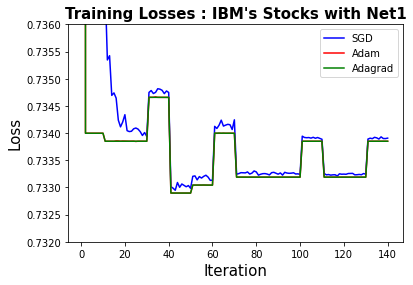

In [ ]:
iterations = np.linspace(1,140,140)
plt.plot(iterations, [float(x) for x in losses_IBM_SGD_1],'b-',iterations, [float(x) for x in losses_IBM_Adam_1],'r-',iterations, [float(x) for x in losses_IBM_Adagrad_1],'g-')
plt.ylim(0.732,0.736)
plt.title("Training Losses : IBM's Stocks with Net1",fontweight="bold",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.xlabel("Iteration",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])


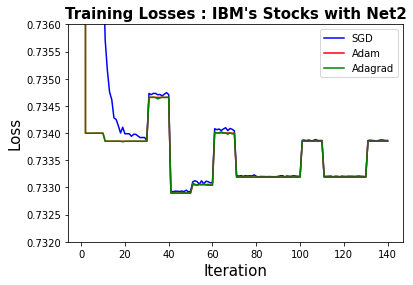

In [ ]:
plt.plot(iterations, [float(x) for x in losses_IBM_SGD_2],'b-',iterations, [float(x) for x in losses_IBM_Adam_2],'r-',iterations, [float(x) for x in losses_IBM_Adagrad_2],'g-')
plt.ylim(0.732,0.736)
plt.title("Training Losses : IBM's Stocks with Net2",fontweight="bold",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.xlabel("Iteration",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])


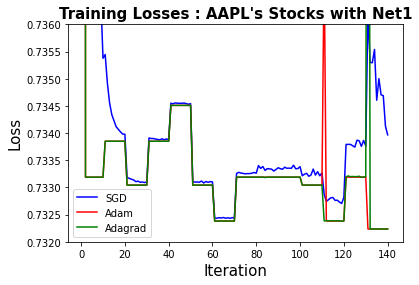

In [ ]:
plt.plot(iterations, [float(x) for x in losses_AAPL_SGD_1],'b-',iterations, [float(x) for x in losses_AAPL_Adam_1],'r-',iterations, [float(x) for x in losses_AAPL_Adagrad_1],'g-')
plt.ylim(0.732,0.736)
plt.title("Training Losses : AAPL's Stocks with Net1",fontweight="bold",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.xlabel("Iteration",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])


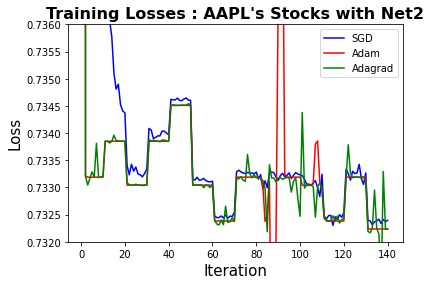

In [ ]:
plt.plot(iterations, [float(x) for x in losses_AAPL_SGD_2],'b-',iterations, [float(x) for x in losses_AAPL_Adam_2],'r-',iterations, [float(x) for x in losses_AAPL_Adagrad_2],'g-')
plt.ylim(0.732,0.736)
plt.title("Training Losses : AAPL's Stocks with Net2",fontweight="bold",fontsize=16)
plt.ylabel("Loss",fontsize=15)
plt.xlabel("Iteration",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])


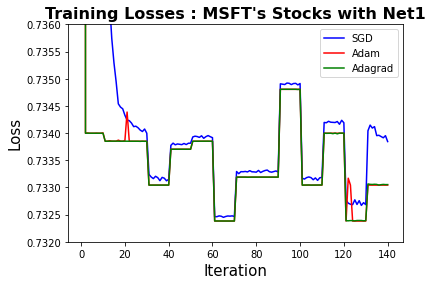

In [ ]:
plt.plot(iterations, [float(x) for x in losses_MSFT_SGD_1],'b-',iterations, [float(x) for x in losses_MSFT_Adam_1],'r-',iterations, [float(x) for x in losses_MSFT_Adagrad_1],'g-')
plt.ylim(0.732,0.736)
plt.title("Training Losses : MSFT's Stocks with Net1",fontweight="bold",fontsize=16)
plt.ylabel("Loss",fontsize=15)
plt.xlabel("Iteration",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])


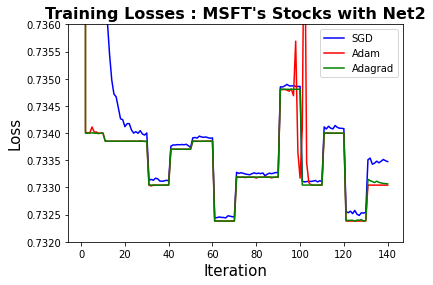

In [ ]:
plt.plot(iterations, [float(x) for x in losses_MSFT_SGD_2],'b-',iterations, [float(x) for x in losses_MSFT_Adam_2],'r-',iterations, [float(x) for x in losses_MSFT_Adagrad_2],'g-')
plt.ylim(0.732,0.736)
plt.title("Training Losses : MSFT's Stocks with Net2",fontweight="bold",fontsize=16)
plt.ylabel("Loss",fontsize=15)
plt.xlabel("Iteration",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])


### **2.3.2 Training Accuracy**

Second, we compare the test accuracy for each training batch

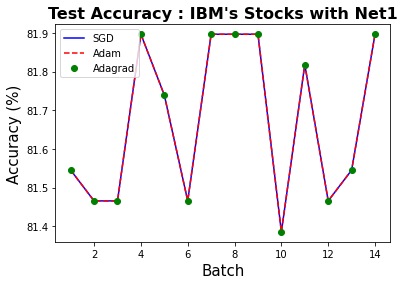

In [ ]:
batches = np.linspace(1,14,14)
plt.plot(batches, [float(x) for x in acc_IBM_SGD_1],'b-',batches, [float(x) for x in acc_IBM_Adam_1],'r--',batches, [float(x) for x in acc_IBM_Adagrad_1],'go')
plt.title("Test Accuracy : IBM's Stocks with Net1",fontweight="bold",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=15)
plt.xlabel("Batch",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])

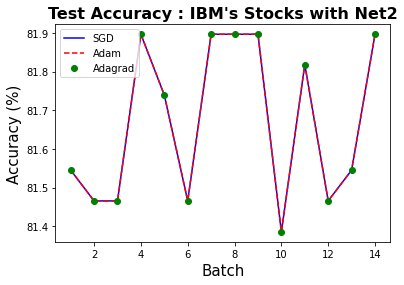

In [ ]:
plt.plot(batches, [float(x) for x in acc_IBM_SGD_2],'b-',batches, [float(x) for x in acc_IBM_Adam_2],'r--',batches, [float(x) for x in acc_IBM_Adagrad_2],'go')
plt.title("Test Accuracy : IBM's Stocks with Net2",fontweight="bold",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=15)
plt.xlabel("Batch",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])

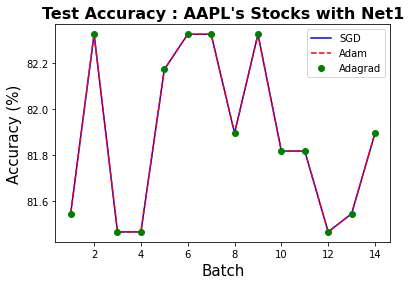

In [ ]:
plt.plot(batches, [float(x) for x in acc_AAPL_SGD_1],'b-',batches, [float(x) for x in acc_AAPL_Adam_1],'r--',batches, [float(x) for x in acc_AAPL_Adagrad_1],'go')
plt.title("Test Accuracy : AAPL's Stocks with Net1",fontweight="bold",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=15)
plt.xlabel("Batch",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])

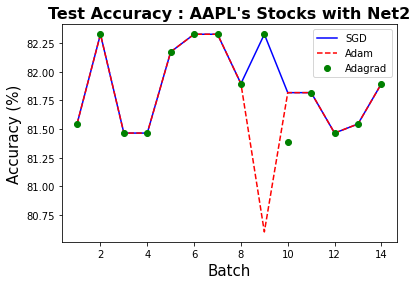

In [ ]:
plt.plot(batches, [float(x) for x in acc_AAPL_SGD_2],'b-',batches, [float(x) for x in acc_AAPL_Adam_2],'r--',batches, [float(x) for x in acc_AAPL_Adagrad_2],'go')
plt.title("Test Accuracy : AAPL's Stocks with Net2",fontweight="bold",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=15)
plt.xlabel("Batch",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])

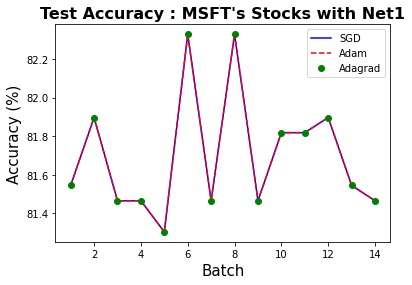

In [ ]:
plt.plot(batches, [float(x) for x in acc_MSFT_SGD_1],'b-',batches, [float(x) for x in acc_MSFT_Adam_1],'r--',batches, [float(x) for x in acc_MSFT_Adagrad_1],'go')
plt.title("Test Accuracy : MSFT's Stocks with Net1",fontweight="bold",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=15)
plt.xlabel("Batch",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])

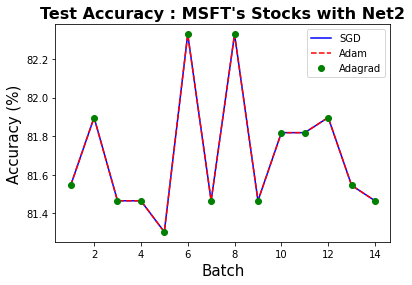

In [ ]:
plt.plot(batches, [float(x) for x in acc_MSFT_SGD_2],'b-',batches, [float(x) for x in acc_MSFT_Adam_2],'r--',batches, [float(x) for x in acc_MSFT_Adagrad_2],'go')
plt.title("Test Accuracy : MSFT's Stocks with Net2",fontweight="bold",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=15)
plt.xlabel("Batch",fontsize=15)
plt.legend(["SGD","Adam","Adagrad"])